# Lab 3 - Visualization

Last update: 11/11/2023

- Name: Thai Chi Vy
- Student ID: 21120169

***

## Work and submission guidelines

**Work on your assignment**

- You need to do your assignment directly in this notebook. First, fill out your name and ID at the beginning of the file. In the notebook, fill in places that say:
```python
#TODO
```

- During your work, you can print out the result, create more cells to test, or create more functions to handle things. Please note that <font color=red>you are not allowed to delete or modify my code cells</font> (except in the case that mentioned above). Remember to remove `raise NotImplementedError("not implement")` when running the code.

- Always press `Ctrl + S` in order to save your work.

**Notes:**

    *  Copy means zero
    *  You have to submit your work on time. No exception
    *  Any questions about your grade are based on the assignment submitted on Moodle
    *  Wrong submission takes you -2 points

**Submit your work**

- When grading your assignment, I will choose `Kernel` - `Restart Kernel & Run All Cells` in order to restart the kernel and run all cells in your notebook. Therefore, you should do that before submitting to ensure that the outputs are all as expected.

- After that, rename you notebook with your student ID (e.g. `1234567.ipynb`) and submit on Moodle.

- <font color=red>Please strictly follow the submission rules.</font>

## Abstract and general requirements

**Abstract**

- In this assignment, you are required to visualize data and results. This task is very important since it provides reader (your clients, your boss,...) an overview of the data as well as your results.

- You will visualize the data in order to answer some questions. By answering these questions, you are able to get some insights from data.

- You will also visualize the results of machine learning model to be able to know whether your model works well or not.

**General requirements**

- Every charts **must have their own name, axes name, legends**.
- The charts you draw must not only be correct but also beautiful:
    - The correctness is shown in choosing the right chart and accurately calculating the data to draw the chart.
    - The beauty is expressed in the UI/UX of the chart. The beauty of UI is shown in choosing the colors, layout of the chart. The beauty of UX is reflected in the fact that the reader can easily capture your message conveyed through your notebook.

---

In [1]:
# visialize stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import json
# !pip install geopandas
import geopandas

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

## Data visualization

- In this section, you are going to compute and visualize some information about Covid-19
- The data prepared in `./data` was collected from Worldometer
- Link: https://www.worldometers.info/coronavirus/

In [2]:
# read the data into a dataframe
df = pd.read_csv('./data/data.csv')
print(f'Shape: {df.shape}')
df.head(5)

Shape: (219, 10)


,Country Name,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Critical Cases,Total Tests,Population
0,USA,"31,990,143",NaN,"576,298",NaN,"24,560,856","6,852,989","9,321","420,822,699","332,516,170"
1,India,"13,689,453","+3,380","171,089",NaN,"12,253,697","1,264,667","8,944","259,207,108","1,390,568,032"
2,Brazil,"13,521,409",NaN,"355,031",NaN,"11,957,068","1,209,310","8,318","28,600,000","213,737,070"
3,France,"5,067,216",NaN,"99,135",NaN,"310,934","4,657,147","5,916","70,140,847","65,386,285"
4,Russia,"4,657,883","+8,173","103,601",338.0,"4,281,776","272,506","2,300","124,100,000","145,983,351"


### Requrement #1: Preprocess

- **TODO**: Take a look at the data files, then go to the URL aforementioned, explore the meaning of columns in the dataset and fill in the blanks:
    - Country Name: Name of country
    - Total Cases: Total number of infected cases
    - New Cases: New infected cases
    - Total Deaths: Total number of deaths by Covid-19
    - New Deaths: New death case
    - Total Recovered: Total number of recovered cases
    - Active Cases: Number of active cases after recovery
    - Critical Cases: Number of critical cases after recovery
    - Total Tests: Total number of Covid-19 tested cases
    - Population: Total number of population

- Check the data with `info()` function

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    object 
 2   New Cases        46 non-null     object 
 3   Total Deaths     219 non-null    object 
 4   New Deaths       32 non-null     float64
 5   Total Recovered  217 non-null    object 
 6   Active Cases     217 non-null    object 
 7   Critical Cases   146 non-null    object 
 8   Total Tests      210 non-null    object 
 9   Population       219 non-null    object 
dtypes: float64(1), object(9)
memory usage: 17.2+ KB


- You can see that `New Cases`, `New Deaths`, `Critical Cases` have a lot of missing data (at least 33.3%). Therefore, we have to remove these columns.
- Most of data in columns are `object` type, which are not suitable at all. They should be converted to integer.
- `Total Recovered`, `Active Cases` and `Total Tests` only have a few missing values, so we can fill in these missing values with median value of each column.

In [4]:
# TODO: drop New Cases, New Deaths, Critical Cases
df = df.drop(['New Cases', 'New Deaths', 'Critical Cases'], axis = 1)
#raise NotImplementedError('not implemented')

# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     219 non-null    object
 1   Total Cases      219 non-null    object
 2   Total Deaths     219 non-null    object
 3   Total Recovered  217 non-null    object
 4   Active Cases     217 non-null    object
 5   Total Tests      210 non-null    object
 6   Population       219 non-null    object
dtypes: object(7)
memory usage: 12.1+ KB


**TODO**: We did handle missing value before. Why do we still have missing values here?

**Answer**: Because the way we have used to handle was not comprehensive. The other columns like `Total Deaths` still have missing values, and we have just dropped high data missing rate columns. 

In [5]:
# TODO: fill in the missing data with median value
def normalize_string(val):
    if type(val) == float or val is None:
        return val
    new_val = val.replace(' ', '')
    if new_val == '':
        return None
    new_val = new_val.replace(',', '')
    return new_val

for col in df.columns:
    if col != 'Country Name':
        df[col] = df[col].apply(normalize_string)

df[['Total Cases', 'Population']] = df[['Total Cases', 'Population']].apply(pd.to_numeric)

df[['Total Deaths',
   'Total Recovered',
   'Active Cases',
   'Total Tests']] = df[['Total Deaths', 
                         'Total Recovered', 
                         'Active Cases', 
                         'Total Tests']].apply(pd.to_numeric)

for col in df.columns:
    if col != 'Country Name':
        med = df[col].median()
        df[col] = df[col].fillna(med)
#raise NotImplementedError('not implemented')

# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int64  
 2   Total Deaths     219 non-null    float64
 3   Total Recovered  219 non-null    float64
 4   Active Cases     219 non-null    float64
 5   Total Tests      219 non-null    float64
 6   Population       219 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 12.1+ KB


**TODO**: Why do we have `float64` here?

**Answer**: I think the reason is to ensure the accuracy of representing numbers.

In [6]:
# TODO: save your new data frame to `./data/new_data.csv`
df.to_csv('./data/new_data.csv', index = False)
#raise NotImplementedError('not implemented')

In [7]:
# TEST
file = open('./data/new_data.csv', 'r')
new_data = file.read()
file.close()

file = open('./data/correct_data.csv', 'r')
correct_data = file.read()
file.close()

assert new_data == correct_data

### Requirement #2: Visualize single variable

- For now, if you do not pass the test, you have to work on the correct file by un-commenting the cell code below to read the `./data/correct_data.csv` into `df`
- You are going to draw 6 bar charts which show all the fields of dataset. For each bar chart, sort the values of countries in descending order and only visualize 5 countries

In [8]:
# # un-comment these lines of code
df = pd.read_csv('./data/correct_data.csv')

df.head()

,Country Name,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Tests,Population
0,USA,31990143,576298.0,24560856.0,6852989.0,420822699.0,332516170
1,India,13689453,171089.0,12253697.0,1264667.0,259207108.0,1390568032
2,Brazil,13521409,355031.0,11957068.0,1209310.0,28600000.0,213737070
3,France,5067216,99135.0,310934.0,4657147.0,70140847.0,65386285
4,Russia,4657883,103601.0,4281776.0,272506.0,124100000.0,145983351


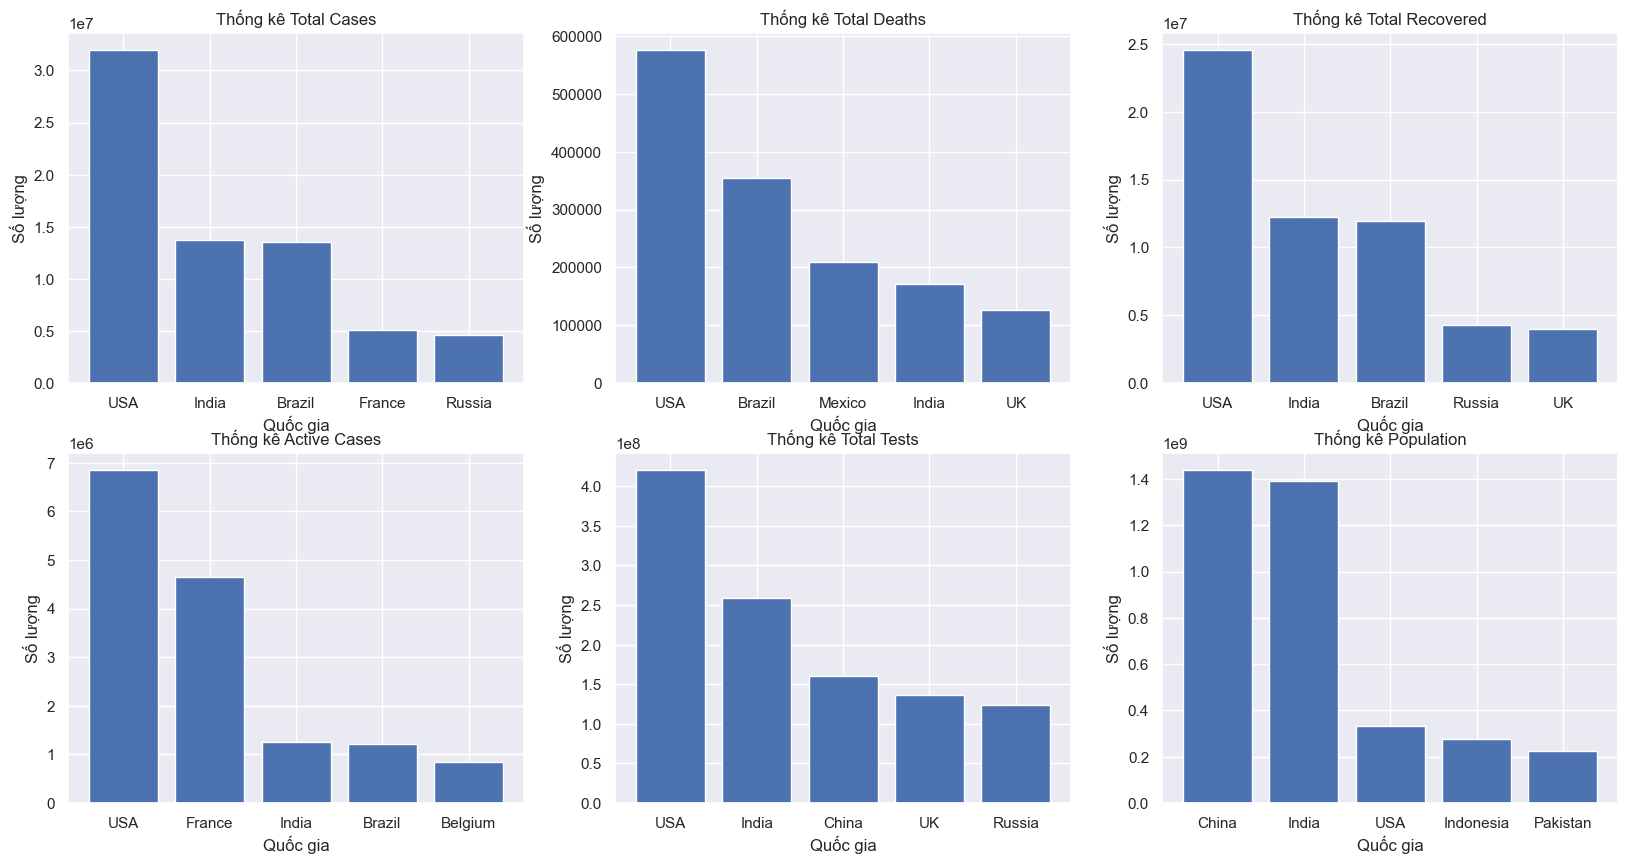

In [10]:
# TODO: draw 6 bar charts
fig, ax = plt.subplots(nrows = 2, ncols = 3)
k = 0
sn.set(rc = {'figure.figsize' : (20, 10)})
for i in range(2):
    for j in range(3):
        plot_df = df[['Country Name', df.columns[k + 1]]]
        plot_df = plot_df.sort_values(ascending = False, by = df.columns[k + 1])
        top5 = plot_df.head(5)
        ax[i, j].bar(top5['Country Name'], top5[df.columns[k + 1]], width = 0.8)
        
        ax[i, j].set_xlabel('Quốc gia')
        ax[i, j].set_ylabel('Số lượng')
        ax[i, j].set_title(f'Thống kê {df.columns[k + 1]}')
        k += 1
#raise NotImplementedError('not implemented')

**TODO**: Comment about the chart

**Answer**:
- USA leads in most indicators, except population. The reason is USE does not believe in using anti-virus vaccines.
- We can see that the countries with high infection levels are mostly Western countries. This can be explained by the adherence to the principles of disease prevention and treatment of Eastern countries.

### Requirement #3: Draw world map

- Using bar chart just gives you a little bit information about numbers
- In this requirement, you are going to draw a world map with circles which shows the number of cases for each country. Specifically, you are provided a file named `coord.json` that contains longitude and latitude of each country. You are going to use `Total cases` and `Total Death` to draw the following charts

C:\Users\DELL\AppData\Local\Temp\ipykernel_16008\3742296096.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  path = geopandas.datasets.get_path('naturalearth_lowres')


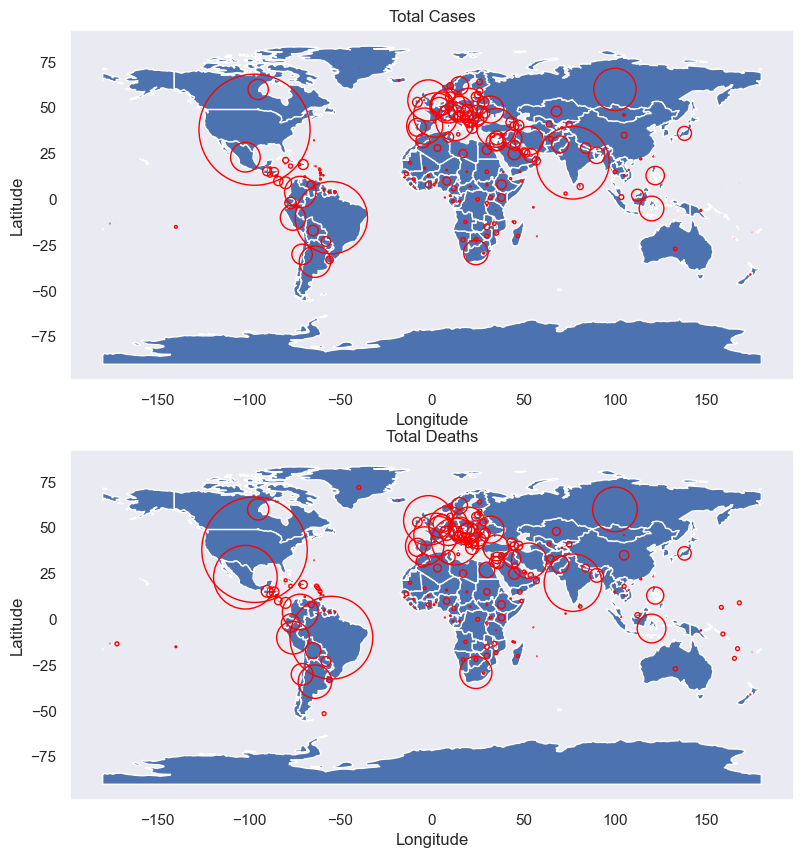

In [11]:
# TODO: draw 2 world map chart using geopandas
path = geopandas.datasets.get_path('naturalearth_lowres')
geo_df = geopandas.read_file(path)

# load coord.json
with open('./data/coord.json', 'r') as file:
    coordinates = json.load(file)
# country
countries = df['Country Name']
# total cases
total_cases = df['Total Cases']
# total deaths
total_deaths = df['Total Deaths']
# get lat, long for countries
lat = [coordinates['lat'][country] if country in coordinates['lat'].keys() else None
       for country in countries]
long = [coordinates['long'][country] if country in coordinates['long'].keys() else None
        for country in countries]

# plot geo dataframe
fig, ax = plt.subplots(2)
geo_df.plot(ax = ax[0])

ax[0].scatter(long, lat, s = total_cases / 5000, marker = 'o', 
            linewidth = 1, facecolors = "None", edgecolor = 'red')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Total Cases')
ax[0].grid()

geo_df.plot(ax = ax[1])

ax[1].scatter(long, lat, s = total_deaths / 100, marker = 'o', 
            linewidth = 1, facecolors = "None", edgecolor = 'red')

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Total Deaths')
ax[1].grid()
#raise NotImplementedError('not implemented')

**TODO**: Comment about the chart

**Answer**: In my observation, I have some comments:
- The infected and death cases are mainly distributed in Europe and America. Meanwhile, Asian countries have fewer cases and death cases.
- Countries with a large number of infected cases and deaths are the USA and Brazil.

### Requirement #4: Relationship between 2 variables

- Exploring the relationship between variables is a needed task to do
- You will start with exploring the linear relationship between 2 variables. In order to do so, draw $C_6^2=15$ scatter plots. For each plot, draw a line that shows the linear relationship of variables. You should implement the line yourself instead of using library.

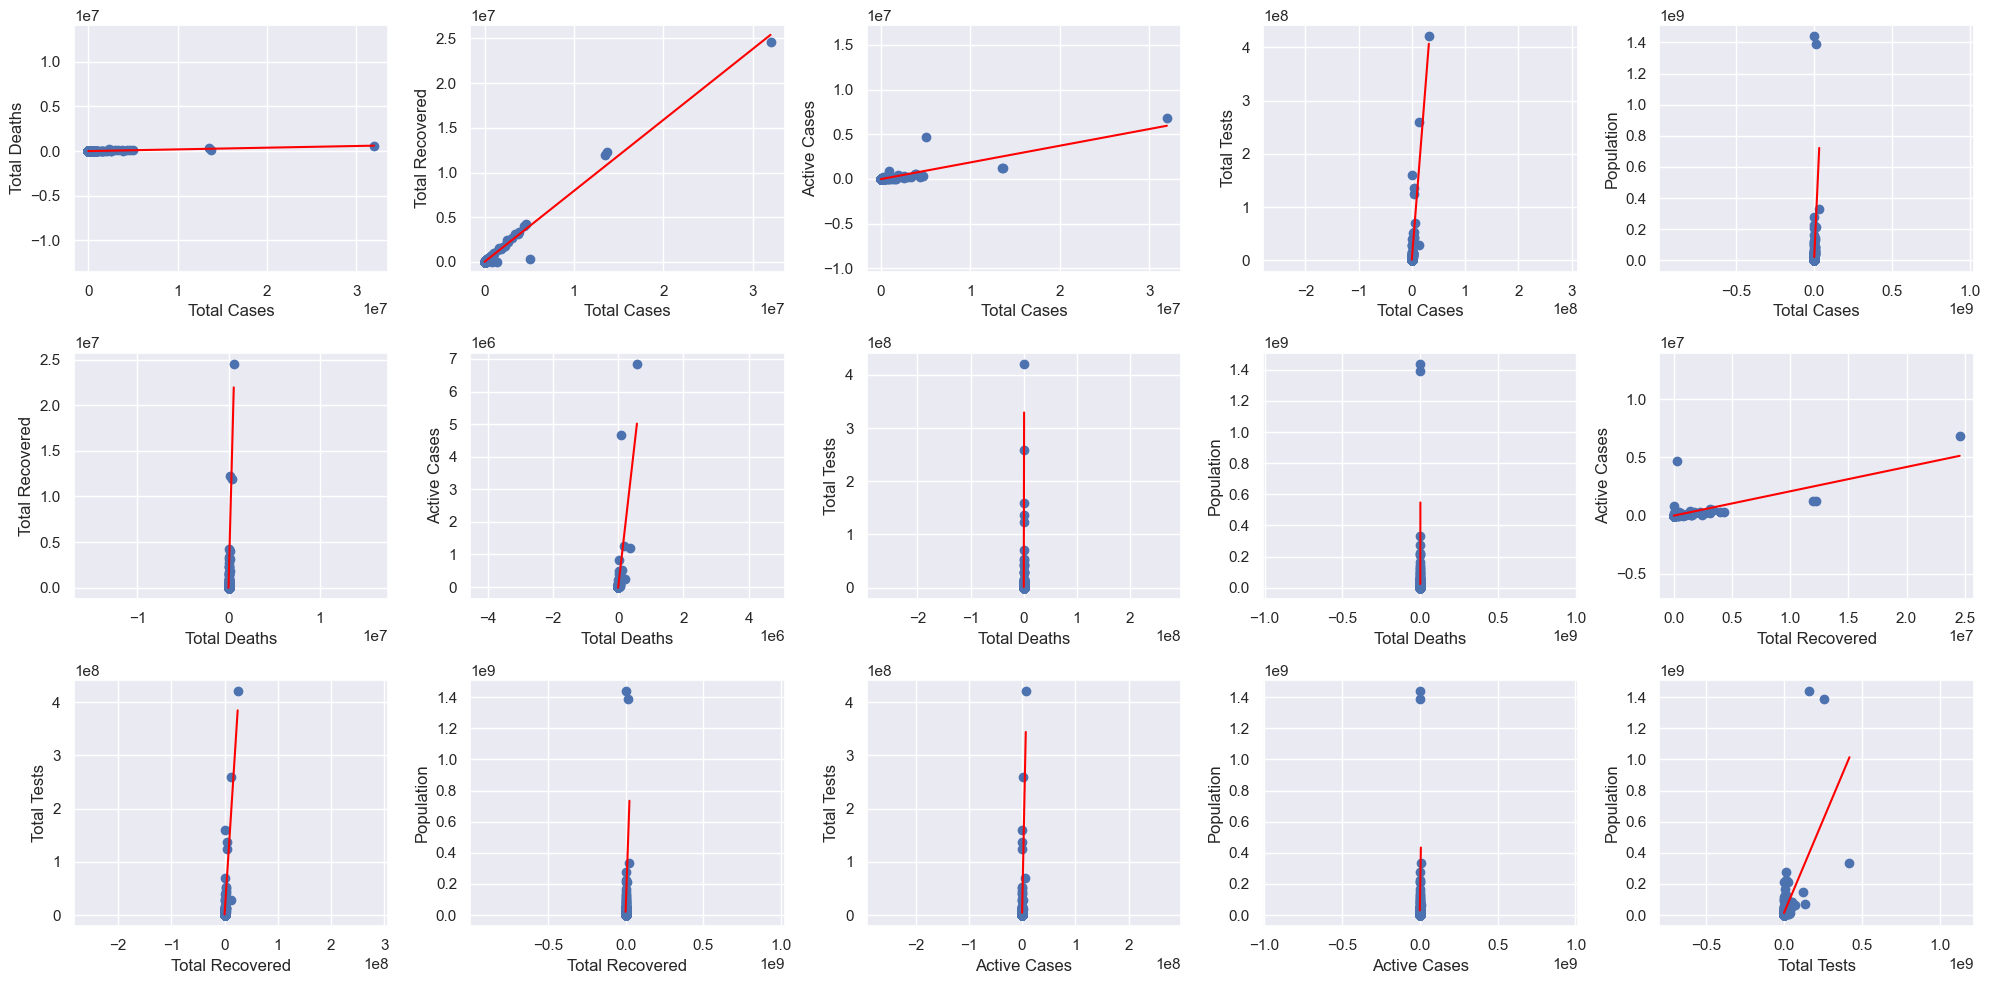

In [12]:
# TODO: scatter stuff
fig, ax = plt.subplots(nrows = 3, ncols = 5, figsize = (20, 10))
column_names = df.columns.drop('Country Name')

row, col = 0, 0
for i in range(0, len(column_names) - 1):
    for j in range(i + 1, len(column_names)):
        x, y = df[column_names[i]], df[column_names[j]]
        # compute the slope and intercept of the linear regression relationship
        m, b = np.polyfit(x, y, 1)
        
        # plot scatter data
        ax[row, col].scatter(x, y, marker = 'o')
        
        # plot linear resgression relationship
        line_x = np.array([min(x), max(x)])
        line_y = m * line_x + b
        
        ax[row, col].plot(line_x, line_y, color = 'red', label = f'Linear Fit: y = {m:.2f}x + {b:.2f}')
        ax[row, col].axis('equal')
        
        ax[row, col].set_xlabel(column_names[i])
        ax[row, col].set_ylabel(column_names[j])
        
        if col == 4:
            col = 0
            row += 1
        else:
            col += 1
plt.tight_layout()
#raise NotImplementedError('not implemented')

**TODO**: As showed above, give your prediction about the relationship between each pair.

**Answer**:
After observing, I can give some predictions about the relationship between each pair:
- No pair shows negative correlation.
- The more infected cases, the more recovered cases.
- The more active cases after recovering, the less death cases.
- A large population does not mean that the number of cases will be high. Moreover, the population will not correlate much with other features.

### Requirement #5: Double check the relationship between 2 variables

- In order to make sure about the linear relationship, you have to check each pair with **Pearson correlation coefficient**
- Specifically, $\rho$ is calculated as follows:

$$\rho_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

- Then, plot these 15 values using heatmap

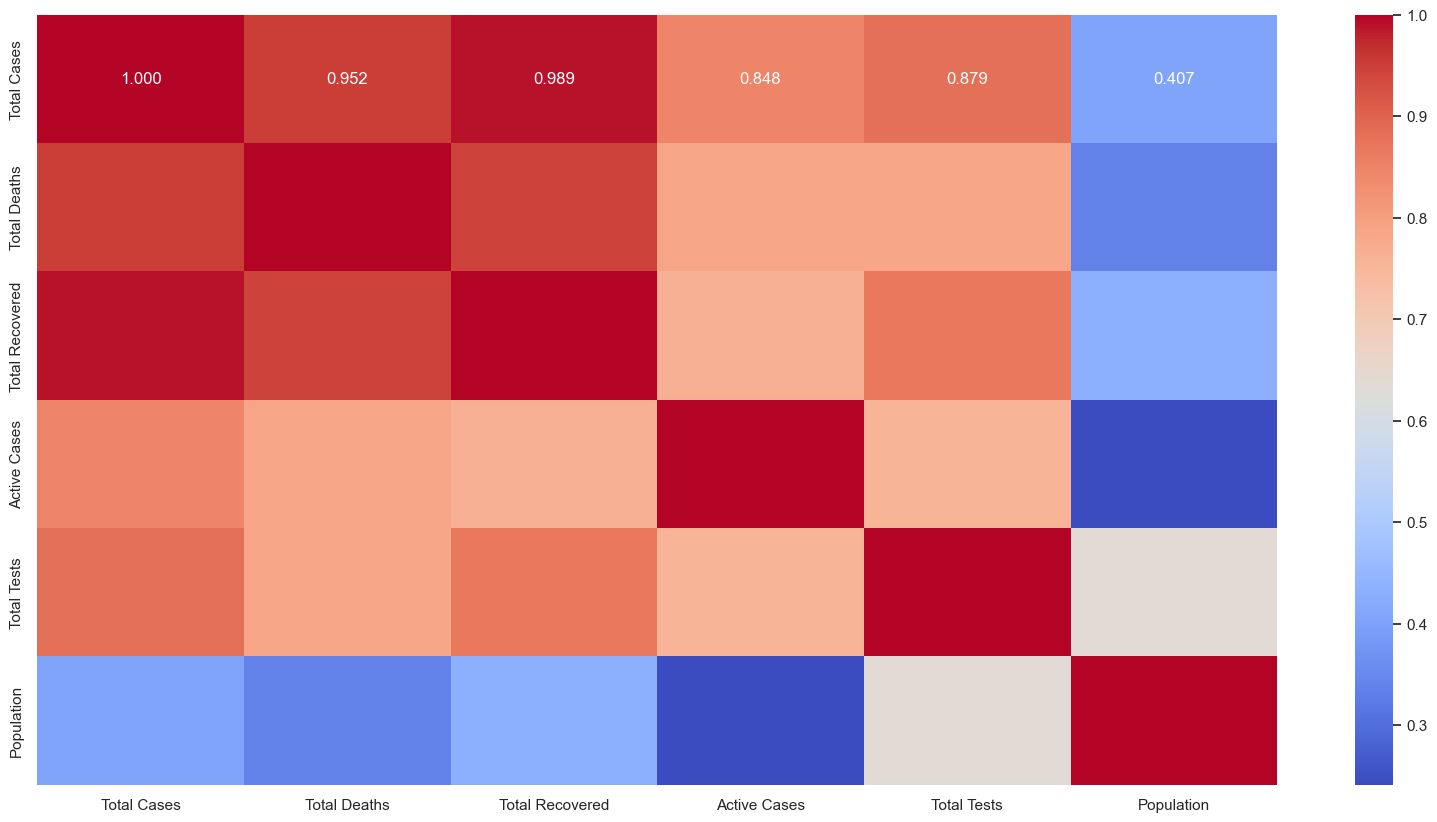

In [13]:
# TODO: create heatmap
corr_matrix = df.copy().drop(columns = ['Country Name']).corr()

#sn.set(rc = {'figure.figsize' : (20, 10)})
sn.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.3f')
plt.show()
#raise NotImplementedError('not implemented')

For now, you can check whether your prediction is right or wrong!

## Model visualization

- In this section, we are going to visualize the training and testing process of machine learning model
- The process of training and testing a model is as follow:
    1. Prepare data for training and testing
    2. Create a model
    3. Train and test the model
    4. Visualize the result

- You are required to:
    1. Study Multi-layer neural network and Convolutional neural network
    2. Study `Pytorch` in order to prepare data and design machine learning model
    3. Design 2 models to classify MNIST dataset. Then, visualize the result of each model and compare the result to each other
        - Model 1: A fully-connected model with 4 layers. The input layer has $784$ neurons. The hidden layer #1 has $1024$ neurons, which is followed by a $ReLU$ as activation functions. The hidden layer #2 has $512$ neurons, also followed by a $ReLU$ as activation functions. The output layer has $10$ neurons (of course), which follows by a $LogSoftmax$ function
        - Model 2: A CNN model with 2 Convolution layers and 1 linear layer. All the CNN layers have 20 filters, kernel size equal to $5$. Each of them is followed by a $ReLU$ activation function and a MaxPooling2D layer ($kernel\_size=2$). The linear layer is followed by a $LogSoftmax$ activation function

- Google Colab can be used since it provides free GPU, which makes your training and testing process faster

### Requirement #6: Prepare data

- `Pytorch` supports a lot of datasets for running machine learning model. In this lab, we use MNIST dataset. So, download the training set and the testing set using `Pytorch` and store them in `./data`
- Note that you have to transform your data into `tensor` (a datatype that's quite similar to `numpy array`) so you can input to model
- After that, create `train_dataloader` and `test_dataloader`

**TODO**: Explain why we have to create dataloader \
**Answer**:
- Firstly, training a model on the entire dataset at once can have an expensive computation and might not fit into the available memory. Therefore, dataloader helps in dividing the dataset into smaller batches, allowing to process a manageable subset of data at a time.
- Secondly, shuffling the data during training is important to prevent the model from learning patterns based on the order of the data. This improves the model's ability to generalize. The Dataloader simplifies the shuffling process for you.
- Finally, dataloader allows you to load batches of data in parallel, taking advantage of multi-core processors. It's essential to speed up the training process.

In [14]:
# TODO: download training, testing data and store them into training_data and testing_data
# Then, create train_dataloader and test_dataloader with batch_size=32
# define the batch size
batch_size = 32

# download MNIST dataset and apply transformations
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = ToTensor())
test_dataset = datasets.MNIST(root='./data', train = False, download = True, transform = ToTensor())

# create train_dataloader and test_dataloader
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
#raise NotImplementedError('not implemented')

- After downloading the data, visualize 10 random samples (2 rows, 5 samples for each row) from training set.

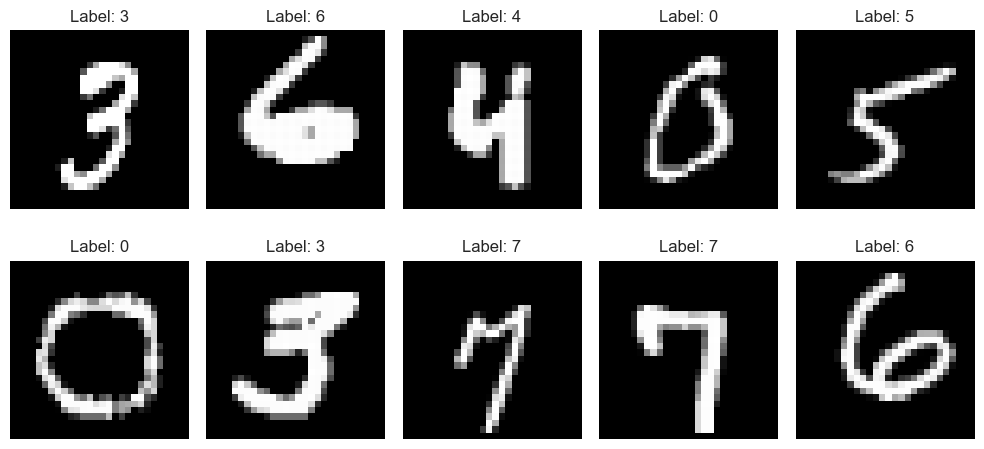

In [15]:
# TODO: visualize 10 random samples
# create data_iter
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize = (10, 5))

# iterate over the random samples and plot them
for i in range(10):
    image = images[i].squeeze()
    label = labels[i]
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
#raise NotImplementedError('not implemented')

### Requirement #7: Create models

- Create 2 models as mentioned above. Call them `Mnist_FC` and `Mnist_CNN`
- **I strongly recommend that you should slowly implement, print out the output and its shape of each layer in order to get a deep understanding of what you are trying to do**
- Before moving to the next requirement, you should test your model with a random sample of the dataset. In case you create code cells for testing, remember to remove these cells

In [25]:
# TODO: create Mnist_FC and Mnist_CNN
import torchvision
# define the fully_connected model (model 1)
class Mnist_FC(nn.Module):
    def __init__(self):
        super(Mnist_FC, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024) # fc1
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512) # fc2
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(512, 10) # output
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output(x)
        x = self.log_softmax(x)
        
        return x
# define the CNN model (model 2)
class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size = 5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(20, 20, kernel_size = 5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(320, 10)
        self.log_softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.log_softmax(x)
        
        return x

# load a random sample from the MNIST dataset for testing
mnist_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = ToTensor())
dataloader = DataLoader(mnist_dataset, batch_size = 1, shuffle = True)
sample_data, sample_label = next(iter(dataloader))

# test FC model
Mnist_FC = Mnist_FC()
output_fc = Mnist_FC(sample_data)
print(f"Model 1 Layers: {output_fc}")
print(f"Model 1 Output Shape: {output_fc.shape}\n")
print("Layer's shape: ")
for name, layer in Mnist_FC.named_children():
    print(f"Layer {name}: {x.shape}")
    
print('-' * 50)
# test CNN model
Mnist_CNN = Mnist_CNN()
output_CNN = Mnist_CNN(sample_data)
print(f"Model 2 Output: {output_CNN}")
print(f"Model 2 Output Shape: {output_CNN.shape}\n") 
for name, layer in Mnist_CNN.named_children():
    print(f"Layer {name}: {x.shape}")
#raise NotImplementedError('not implemented')

Model 1 Layers: tensor([[-2.2777, -2.2767, -2.3321, -2.3360, -2.3566, -2.3053, -2.3237, -2.2759,
         -2.3071, -2.2404]], grad_fn=<LogSoftmaxBackward0>)
Model 1 Output Shape: torch.Size([1, 10])

Layer's shape: 
Layer flatten: torch.Size([1, 784])
Layer fc1: torch.Size([1, 784])
Layer relu1: torch.Size([1, 784])
Layer fc2: torch.Size([1, 784])
Layer relu2: torch.Size([1, 784])
Layer output: torch.Size([1, 784])
Layer log_softmax: torch.Size([1, 784])
--------------------------------------------------
Model 2 Output: tensor([[-2.2620, -2.2544, -2.2461, -2.4216, -2.3594, -2.3491, -2.2740, -2.3202,
         -2.2505, -2.3037]], grad_fn=<LogSoftmaxBackward0>)
Model 2 Output Shape: torch.Size([1, 10])

Layer conv1: torch.Size([1, 784])
Layer relu1: torch.Size([1, 784])
Layer maxpool1: torch.Size([1, 784])
Layer conv2: torch.Size([1, 784])
Layer relu2: torch.Size([1, 784])
Layer maxpool2: torch.Size([1, 784])
Layer flatten: torch.Size([1, 784])
Layer fc: torch.Size([1, 784])
Layer log_sof

### Requirement #8: Train and test models

- Design `train` and `test` function with the parameters provided in the following code cell
    - `train` function trains the model with all the data in training set
    - `test` function tests the model with all data in testing set

- Return the accuracy (e.g. $0.847351$) after training and testing

**TODO**: Explain the parameters of `train` and `test` function. In `test` function, there is a line of code that says `with torch.no_grad()`. Why do we have this line of code?

**Answer**: 
`with torch.no_grad()` is used during the testing phase to ensure that gradient computation is turned off, providing efficiency and speed benefits.

In [26]:
# TODO: design train and test function
# check gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} for training and testing')

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = running_loss / len(dataloader)

    return accuracy, average_loss
    #raise NotImplementedError('not implemented')

def test(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = running_loss / len(dataloader)

    return accuracy, average_loss
    #raise NotImplementedError('not implemented')

Using cpu for training and testing


- Run 20 epochs for each model. In order to do so, at fist, you have to define `learning_rate, loss_fn` and `optimizer`. I will help you on that

- Save the history of training and testing process as `history_fc` and `history_cnn`. During the running process, you should print out the accuracy in order to keep track

- The history is a dictionary with the following structure:

```python
history = {
    1: [0.6, 0.5], # the key (type: int) is the epoch
    2: [0.7, 0.6], # the value (type: list) contains the accuracy of training and testing process at the corresponding epoch
    ...
}
```

**TODO**: List out some loss functions and optimizers that you have heard about

**Answer**:
- Loss Functions: CrossEntropyLoss, MSELoss, BCELoss, etc.
- Optimizers: SGD, Adam, RMSprop, etc.

In [27]:
# TODO: run 20 epochs for Mnist_FC and Mnist_CNN
# design loss and optimizer functions
loss_fn = nn.CrossEntropyLoss()
optimizer_fc = torch.optim.Adam(Mnist_FC.parameters(), lr=0.001)
optimizer_cnn = torch.optim.Adam(Mnist_CNN.parameters(), lr=0.001)

epochs = 20
history_fc = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}
history_cnn = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}

for epoch in range(epochs):
    # train Model 1 (Fully-Connected)
    train_acc_fc, train_loss_fc = train(train_dataloader, Mnist_FC, loss_fn, optimizer_fc)
    test_acc_fc, test_loss_fc = test(test_dataloader, Mnist_FC)

    # save history for Model 1
    history_fc['train_acc'].append(train_acc_fc)
    history_fc['train_loss'].append(train_loss_fc)
    history_fc['test_acc'].append(test_acc_fc)
    history_fc['test_loss'].append(test_loss_fc)

    # train Model 2 (CNN)
    train_acc_cnn, train_loss_cnn = train(train_dataloader, Mnist_CNN, loss_fn, optimizer_cnn)
    test_acc_cnn, test_loss_cnn = test(test_dataloader, Mnist_CNN)

    # save history for Model 2
    history_cnn['train_acc'].append(train_acc_cnn)
    history_cnn['train_loss'].append(train_loss_cnn)
    history_cnn['test_acc'].append(test_acc_cnn)
    history_cnn['test_loss'].append(test_loss_cnn)

    # print the progress
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Model 1 - Train Accuracy: {train_acc_fc * 100:.2f}%, Test Accuracy: {test_acc_fc * 100:.2f}%, '
          f'Model 2 - Train Accuracy: {train_acc_cnn * 100:.2f}%, Test Accuracy: {test_acc_cnn * 100:.2f}%')
#raise NotImplementedError('not implemented')

Epoch 1/20, Model 1 - Train Accuracy: 94.26%, Test Accuracy: 96.92%, Model 2 - Train Accuracy: 94.70%, Test Accuracy: 97.65%
Epoch 2/20, Model 1 - Train Accuracy: 97.38%, Test Accuracy: 97.77%, Model 2 - Train Accuracy: 98.22%, Test Accuracy: 98.36%
Epoch 3/20, Model 1 - Train Accuracy: 98.19%, Test Accuracy: 98.05%, Model 2 - Train Accuracy: 98.64%, Test Accuracy: 99.02%
Epoch 4/20, Model 1 - Train Accuracy: 98.66%, Test Accuracy: 97.96%, Model 2 - Train Accuracy: 98.86%, Test Accuracy: 98.85%
Epoch 5/20, Model 1 - Train Accuracy: 98.91%, Test Accuracy: 97.93%, Model 2 - Train Accuracy: 99.11%, Test Accuracy: 99.13%
Epoch 6/20, Model 1 - Train Accuracy: 99.06%, Test Accuracy: 98.00%, Model 2 - Train Accuracy: 99.24%, Test Accuracy: 98.85%
Epoch 7/20, Model 1 - Train Accuracy: 99.19%, Test Accuracy: 97.81%, Model 2 - Train Accuracy: 99.35%, Test Accuracy: 99.05%
Epoch 8/20, Model 1 - Train Accuracy: 99.28%, Test Accuracy: 98.09%, Model 2 - Train Accuracy: 99.41%, Test Accuracy: 98.97%


### Requirement #9: Visualize

- Produce a graph as the following code cell and comment about the running process of 2 models

**TODO**: Your comment

**Answer**:
- Both models start with high training and testing accuracies in the first epochs.
- Throughout the epochs, both models consistently improve their training and testing accuracies.
- Model 2 generally outperforms Model 1 in terms of both traning and testing accuracies.
- It is notable that, despite the high accuracy, the improvement rate tends to decrease in the later epochs.

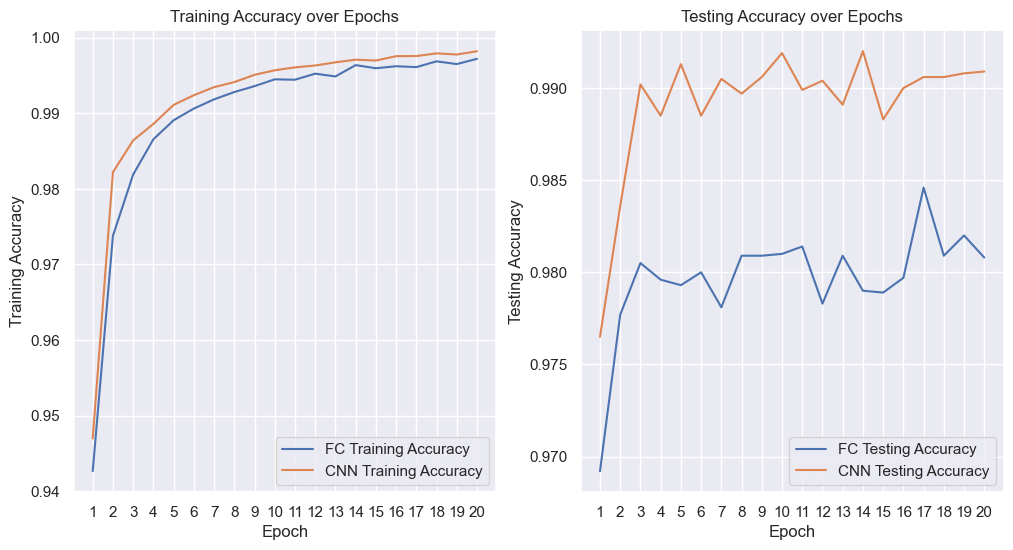

In [28]:
# TODO: visualize the history
epochs = range(1, 21)

# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_fc['train_acc'], label='FC Training Accuracy')
plt.plot(epochs, history_cnn['train_acc'], label='CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xticks(epochs)
plt.legend()

# Plot testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_fc['test_acc'], label='FC Testing Accuracy')
plt.plot(epochs, history_cnn['test_acc'], label='CNN Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.xticks(epochs)
plt.legend()

plt.show()
#raise NotImplementedError('not implemented')

- Highly recommend you go play around with the parameters of models and re-implement 2 models using `TensorFlow` on Colab